**Machine Learning for Time Series (Master MVA)**

- TP1, Friday 29<sup>th</sup> January 2021
- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this notebook, we illustrate two concepts:
- convolutional dictionary learning (CDL),
- dynamic time warping (DTW).

## Setup

**Import**

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from dtw import dtw
from IPython.display import Audio, display
from loadmydata.load_uea_ucr import load_uea_ucr_data
from matplotlib.colors import rgb2hex
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
from sporco import plot, util
from sporco.admm import cbpdn
from sporco.dictlrn import cbpdndl

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



**Utility functions**

In [2]:
def plot_CDL(signal, Z, D, figsize=(15, 10)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    (atom_length, n_atoms) = np.shape(D)
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(D[:, i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
        plt.plot(Z[:, i])
        plt.ylim((np.min(Z), np.max(Z)))

In [3]:
def atleast_2d(ary):
    """Reshape array to at least two dimensions."""
    if ary.ndim == 0:
        return ary.reshape(1, 1)
    elif ary.ndim == 1:
        return ary[:, np.newaxis]
    return ary

In [4]:
def display_distance_matrix_as_table(
    distance_matrix, labels=None, figsize=(8, 2)
):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("tight")
    ax.axis("off")
    norm = mpl.colors.Normalize()
    cell_colours_hex = np.empty(shape=distance_matrix.shape, dtype=object)
    cell_colours_rgba = plt.get_cmap("magma")(norm(distance_matrix))

    for i in range(distance_matrix.shape[0]):
        for j in range(i + 1, distance_matrix.shape[0]):
            cell_colours_hex[i, j] = rgb2hex(
                cell_colours_rgba[i, j], keep_alpha=True
            )
            cell_colours_hex[j, i] = cell_colours_hex[i, j]

    if labels is not None:
        _ = ax.table(
            cellText=distance_matrix,
            colLabels=labels,
            rowLabels=labels,
            loc="center",
            cellColours=cell_colours_hex,
        )
    else:
        _ = ax.table(
            cellText=distance_matrix,
            loc="center",
            cellColours=cell_colours_hex,
        )

    return ax

In [5]:
def get_n_largest(
    arr: np.ndarray, n_largest: int = 3
) -> (np.ndarray, np.ndarray):
    """Return the n largest values and associated indexes of an array.

    (In decreasing order of value.)
    """
    indexes = np.argsort(arr)[-n_largest:][::-1]
    if n_largest == 1:
        indexes = np.array(indexes)
    values = np.take(arr, indexes)
    return values, indexes

In [6]:
def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

# Convolutional dictionary learning (CDL)

## Data

In [64]:
dataset_name = "BinaryHeartbeat"
data = load_uea_ucr_data(dataset_name)
print(data.description)

Task is to classify the nature of the heartbeat signal.

Heart sound recordings were sourced from several contributors around the world, collected at either a clinical or nonclinical environment, from both healthy subjects and pathological patients.
Each series represent the aplitude of the singal over time.

Heart sound recordings were sourced from several contributors around the world, collected at either a clinical or nonclinical environment, from both healthy subjects and pathological patients.
The heart sound recordings were collected from different locations on the body. The typical four locations are aortic area, pulmonic area, tricuspid area and mitral area, but could be one of nine different locations.
The sounds were divided into two classes: normal and abnormal. The normal recordings were from healthy subjects and the abnormal ones were from patients with a confirmed cardiac diagnosis.
The patients suffer from a variety of illnesses, but typically they are heart valve defect

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What is the sampling frequency of those sounds?</p>
</div>

In [66]:
FREQUENCY = 2000  # Hz

We can plot a signal from each class (normal and abnormal).


Training set:	204 time series with 18530 samples and 1 dimension.
Testing set:	205 time series with 18530 samples and 1 dimension.



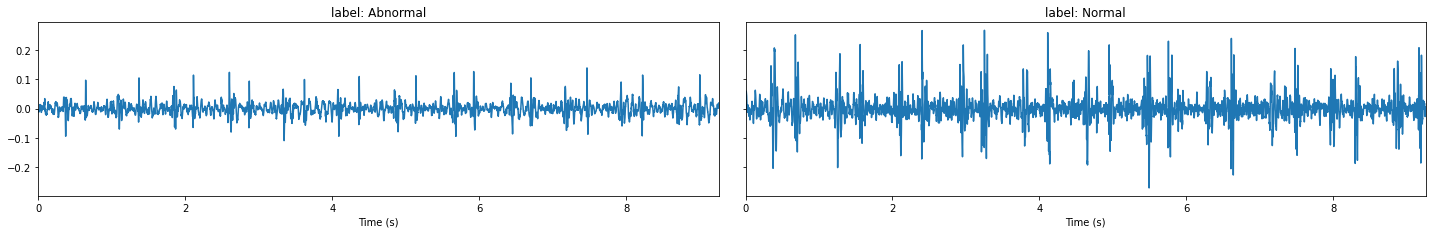

In [67]:
msg = "{title} set:\t{n_series} time series with {n_samples} samples and {n_dims} dimension."
for title, X in zip(("Training", "Testing"), (data.X_train, data.X_test)):
    n_series, n_samples, n_dims = X.shape
    print(
        msg.format(
            title=title, n_series=n_series, n_samples=n_samples, n_dims=n_dims
        )
    )
print()

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(20, 3), sharey=True)
fig.tight_layout()
for ind, ax in zip([1, 200], ax_arr):
    s = data.X_train[ind]
    tt = np.arange(s.size) / FREQUENCY
    ax.plot(tt, s)
    ax.set_xlim(0, s.size / FREQUENCY)
    ax.set_xlabel("Time (s)")
    _ = ax.set_title(f"label: {data.y_train[ind]}")

In [68]:
# Since the time series are sound signals, we can choose one and listen to it.

for ind in [1, 200]:
    signal = data.X_train[ind]
    label = data.y_train[ind]
    print(label)
    display(Audio(signal.flatten(), rate=FREQUENCY))

Abnormal
Normal


For the subsequent study, we select only 6 elements (3 from each classe) from the complete data set.

In [69]:
sub_sample = [0, 1, 2, 190, 191, 192]  # 3 Normal, 3 Abnormal
X = np.take(data.X_train, sub_sample, axis=0)  # shape (n_series, n_samples, 1)
y = np.take(data.y_train, sub_sample, axis=0)  # shape (n_series,)

# normalize signals (zero mean, unit variance).
X -= X.mean(axis=1).reshape(-1, 1, 1)
X /= X.std(axis=1).reshape(-1, 1, 1)

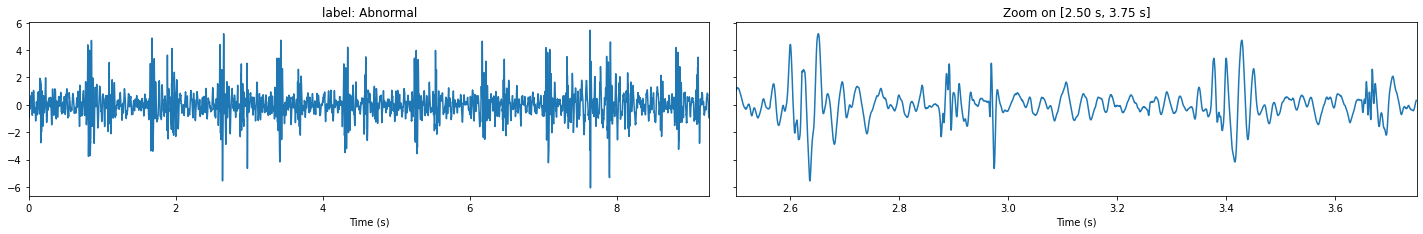

In [70]:
ind = 0
signal = X[ind]
label = y[ind]

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(20, 3), sharey=True)
fig.tight_layout()
ax = ax_arr[0]

n_samples = signal.size
tt = np.arange(n_samples) / FREQUENCY
ax.plot(tt, signal)
ax.set_xlabel("Time (s)")
ax.set_xlim(0, n_samples / FREQUENCY)

ax.set_title(f"label: {label}")

ax = ax_arr[1]
start, end = 5000, 7500  # change here to zoom somewhere else
ax.plot(tt[start:end], signal[start:end])
ax.set_xlim(tt[start], tt[end])
ax.set_xlabel("Time (s)")
_ = ax.set_title(f"Zoom on [{start/FREQUENCY:.2f} s, {end/FREQUENCY:.2f} s]")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Roughly, what is the duration of the important phenomenon (the heartbeat)?</p>
</div>

In [72]:
0.7 sec

## CDL on a single signal

For a 1D signal $\mathbf{x}\in\mathbb{R}^N $ with $N$ samples, the convolutional dictionary learning tasks amounts to solving the following optimization problem:

$
\min_{(\mathbf{d}_k)_k, (\mathbf{z}_k)_k \\ \lVert\mathbf{d}_k\rVert^2\leq 1} \quad\left\lVert \mathbf{x} - \sum_{k=1}^K \mathbf{z}_k * \mathbf{d}_k \right\rVert^2 \quad + \quad\lambda \sum_{k=1}^K \lVert\mathbf{z}_k\rVert_1
$

where $ \mathbf{d}_k\in\mathbb{R}^L$ are the $K$ dictionary atoms (patterns), $\mathbf{z}_k\in\mathbb{R}^{N-L+1}$ are activations signals, and $\lambda>0$ is the sparsity constraint.

This problem is not convex with respect to the couple $(\mathbf{d}_k)_k, (\mathbf{z}_k)_k$ but convex when the subproblems are taken individually.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are the parameters that a user must calibrate when using CDL?</p>
</div>

In [ ]:
We need to choose lambda(penalty) , number of atoms(nombre des motifs)
and atom length(longueur des motifs)


We can now apply CDL on a single signal.

In [74]:
# In this cell, we set parameters and options that should probably remained unchanged
PENALTY = 3

# options for the dictionary learning and sparse coding procedures
def get_opt_dl(penalty=PENALTY):
    """Return the option class for the dictionary learning"""
    return cbpdndl.ConvBPDNDictLearn.Options(
        {
            "Verbose": False,
            "MaxMainIter": 50,
            "CBPDN": {"rho": 50.0 * penalty + 0.5, "NonNegCoef": True},
            "CCMOD": {"rho": 10.0},
        },
        dmethod="cns",
    )


def get_opt_sc():
    """Return the option class for the sparse coding"""
    return cbpdn.ConvBPDN.Options(
        {
            "Verbose": False,
            "MaxMainIter": 50,
            "RelStopTol": 5e-3,
            "AuxVarObj": False,
            "NonNegCoef": True,  # only positive sparse codes
        }
    )

In [109]:
# Parameters to change
n_atoms = 3
atom_length = 1000
penalty = 6

# Select a signal
signal = X[2]
signal = atleast_2d(signal)  # reshape

# Random number generator
rng = np.random.RandomState(seed=123)

In [110]:
# get options for the optimizations
opt_dl = get_opt_dl(penalty=penalty)
opt_sc = get_opt_sc()

# Dictionary learning and sparse coding
dict_learning = cbpdndl.ConvBPDNDictLearn(
    D0=rng.randn(atom_length, 1, n_atoms),  # random init
    S=signal,  # signal at hand
    lmbda=penalty,  # sparsity penalty
    opt=opt_dl,  # options for the optimizations
    xmethod="admm",  # optimization method (sparse coding)
    dmethod="cns",  # optimization method (dict learnin)
)
atom_dictionary = dict_learning.solve()

# retrieve the sparse codes
basis_pursuit = cbpdn.ConvBPDN(
    D=atom_dictionary,  # learned dictionary
    S=signal,  # signal at hand
    lmbda=penalty,  # sparsity penalty
    opt=opt_sc,  # options for the optimizations
)
sparse_codes = basis_pursuit.solve().squeeze()

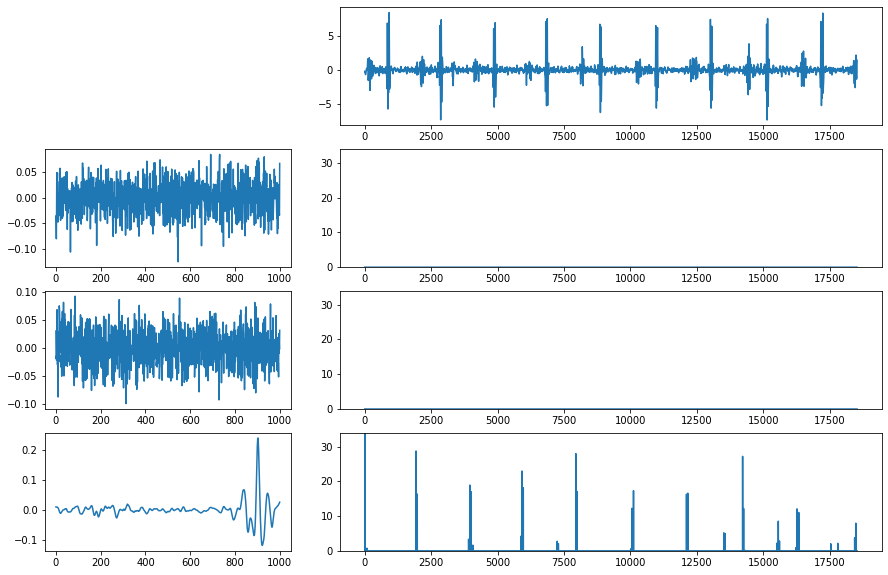

In [111]:
plot_CDL(
    signal, atleast_2d(sparse_codes), atleast_2d(atom_dictionary.squeeze())
)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How does the number of activation evolve when the sparsity penalty changes?</p>
</div>

We can now apply CDL on a single signal.


In [143]:
# Parameters to change
n_atoms = 3
atom_length = 1000
penalty = 60

# Select a signal
signal = X[2]
signal = atleast_2d(signal)  # reshape

# Random number generator
rng = np.random.RandomState(seed=123)

In [144]:
# get options for the optimizations
opt_dl = get_opt_dl(penalty=penalty)
opt_sc = get_opt_sc()

# Dictionary learning and sparse coding
dict_learning = cbpdndl.ConvBPDNDictLearn(
    D0=rng.randn(atom_length, 1, n_atoms),  # random init
    S=signal,  # signal at hand
    lmbda=penalty,  # sparsity penalty
    opt=opt_dl,  # options for the optimizations
    xmethod="admm",  # optimization method (sparse coding)
    dmethod="cns",  # optimization method (dict learnin)
)
atom_dictionary = dict_learning.solve()

# retrieve the sparse codes
basis_pursuit = cbpdn.ConvBPDN(
    D=atom_dictionary,  # learned dictionary
    S=signal,  # signal at hand
    lmbda=penalty,  # sparsity penalty
    opt=opt_sc,  # options for the optimizations
)
sparse_codes = basis_pursuit.solve().squeeze()

<ipython-input-59-5449bf42eee2>:15: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  plt.ylim((np.min(Z), np.max(Z)))
<ipython-input-59-5449bf42eee2>:15: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  plt.ylim((np.min(Z), np.max(Z)))
<ipython-input-59-5449bf42eee2>:15: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  plt.ylim((np.min(Z), np.max(Z)))


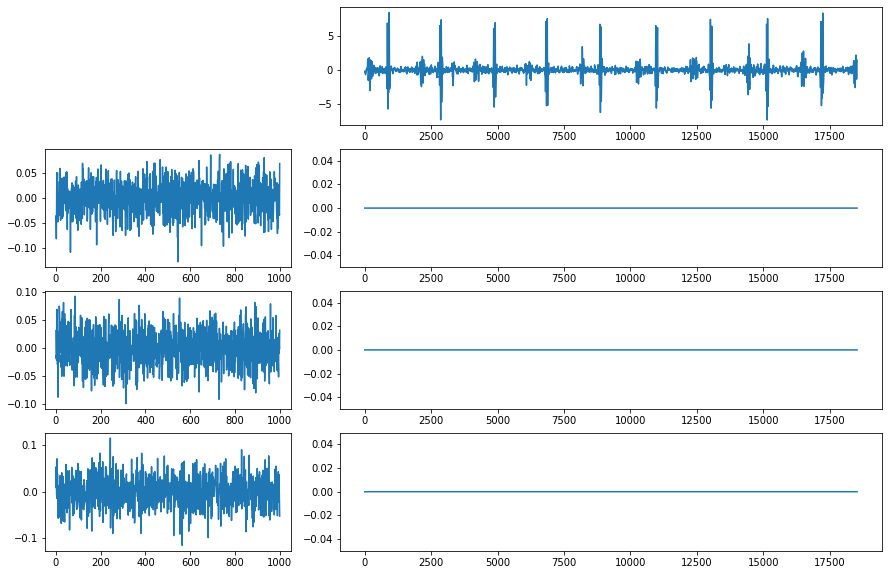

In [145]:
plot_CDL(
    signal, atleast_2d(sparse_codes), atleast_2d(atom_dictionary.squeeze())
)

**Answer 1 :**

when we have a large penalty we will have few activations to none and when we have
a small penalty we will have a lot of activations since we could capture white noise


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Looking at the sparse codes, can you tell:</p>
    <ul>    
    <li>How many times each atom is activated?</li>
    <li>What is the compression rate (number of non-zero coefficients in the sparse codes / signal length)?</li>
    </ul>
</div>

In [114]:
#number of activation of atom1
len(sparse_codes[:,0][sparse_codes[:,0]!=0])


0

In [115]:
#number of activation of atom2
len(sparse_codes[:,1][sparse_codes[:,1]!=0])


0

In [116]:
#number of activation of atom3
len(sparse_codes[:,2][sparse_codes[:,2]!=0])



50

In [117]:
#compression rate
len(sparse_codes[sparse_codes!=0])/len(sparse_codes)


0.002698327037236913

Listen to the learned dictionary.

In [118]:
for (k, atom) in enumerate(atleast_2d(atom_dictionary.squeeze()).T):
    print(f"Atom {k}")
    display(Audio(atom, rate=FREQUENCY))

Atom 0
Atom 1
Atom 2


Now, we look at the reconstruction error.

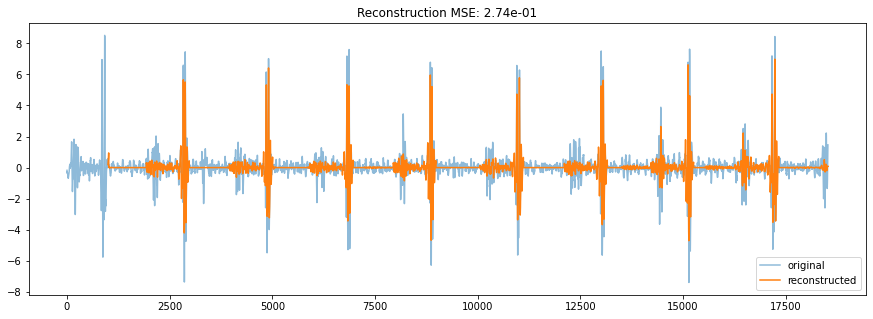

In [119]:
# Reconstruction with the dictionary and the sparse codes
reconstruction = np.stack(
    [
        np.convolve(code, atom, mode="valid")
        for (code, atom) in zip(
            atleast_2d(sparse_codes).T, atleast_2d(atom_dictionary.squeeze()).T
        )
    ],
    axis=0,
)

# Note that the reconstruction has less samples than the original signal.
# This is because of border effects of the convolution.
offset = atom_length - 1

fig, ax = fig_ax()
tt = np.arange(signal.shape[0])
ax.plot(tt, signal, label="original", alpha=0.5)
ax.plot(tt[offset:], reconstruction.sum(axis=0), label="reconstructed")
ax.set_title(
    f"Reconstruction MSE: {np.mean((signal[offset :].flatten() - reconstruction.sum(axis=0))**2):.2e}"
)
_ = plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How does reconstruction error evolve when the sparsity penalty changes?</p>
</div>

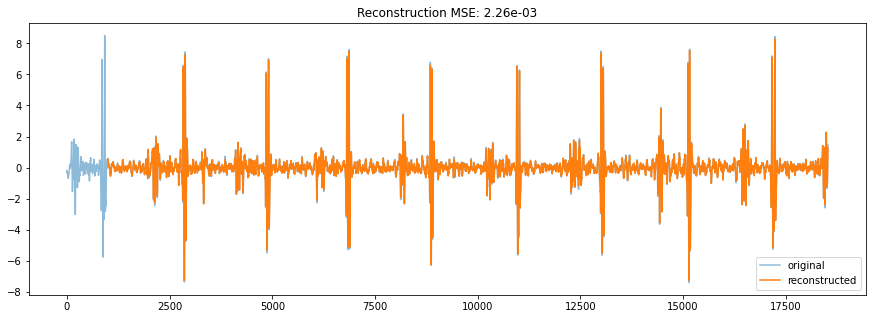

In [108]:
reconstruction = np.stack(
    [
        np.convolve(code, atom, mode="valid")
        for (code, atom) in zip(
            atleast_2d(sparse_codes).T, atleast_2d(atom_dictionary.squeeze()).T
        )
    ],
    axis=0,
)

# Note that the reconstruction has less samples than the original signal.
# This is because of border effects of the convolution.
offset = atom_length - 1

fig, ax = fig_ax()
tt = np.arange(signal.shape[0])
ax.plot(tt, signal, label="original", alpha=0.5)
ax.plot(tt[offset:], reconstruction.sum(axis=0), label="reconstructed")
ax.set_title(
    f"Reconstruction MSE: {np.mean((signal[offset :].flatten() - reconstruction.sum(axis=0))**2):.2e}"
)
_ = plt.legend()

**Answer 2 :**
when the penalty is small we will almost reproduce the signal so the
error is close to zero, when the penalty is too large we won t learn
anything so the error is too large

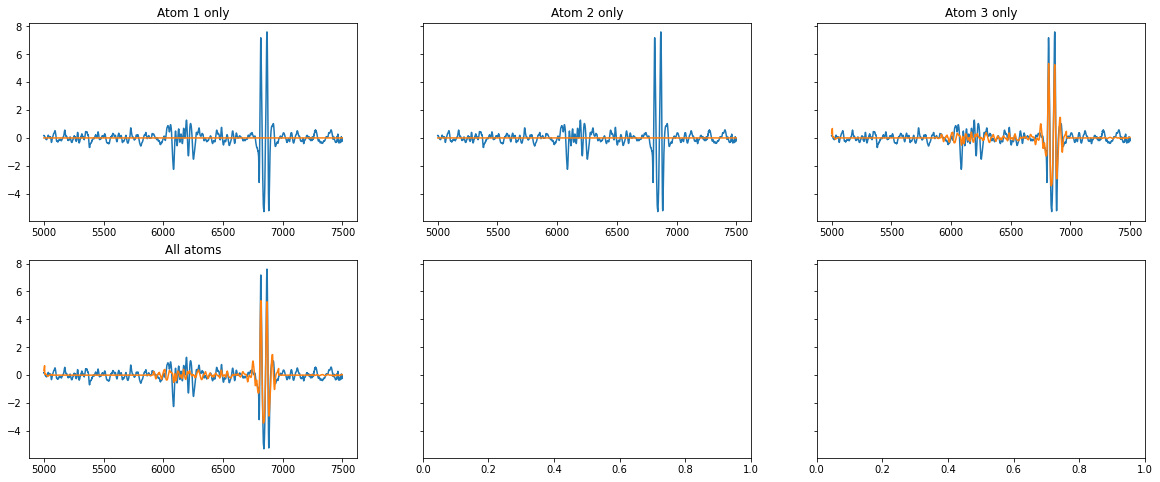

In [120]:
fig, ax_arr = plt.subplots(
    nrows=n_atoms // 3 + 1,
    ncols=3,
    figsize=(20, 4 * (n_atoms // 3 + 1)),
    sharey=True,
)

for (k, (ax, reconstruted_with_one_atom)) in enumerate(
    zip(ax_arr.flatten(), reconstruction), start=1
):
    ax.plot(range(start, end), signal[start:end])
    ax.plot(
        range(start, end),
        reconstruted_with_one_atom[start - offset : end - offset],
    )
    ax.set_title(f"Atom {k} only")

ax = ax_arr.flatten()[n_atoms]
ax.plot(range(start, end), signal[start:end])
ax.plot(
    range(start, end),
    reconstruction.sum(axis=0)[start - offset : end - offset],
)
_ = ax.set_title(f"All atoms")


For easier access, we create the following functions
- `learn_dict(signal, D0, penalty=PENALTY)` which returns the dictionary of atoms (`D0` is the dictionary initialization);
- `learn_codes(signal, atom_dict, penalty=PENALTY)` which return the sparse codes;
- `compute_error(signal, atom_dict, codes)` which returns the MSE of the reconstruction.


In [121]:
def learn_dict(signal, D0, penalty=PENALTY):
    """Return the learned dictionaty"""
    opt_dl = get_opt_dl()
    return cbpdndl.ConvBPDNDictLearn(
        D0=D0, S=signal, lmbda=penalty, opt=opt_dl
    ).solve()


def learn_codes(signal, atom_dictionary, penalty=PENALTY):
    """Return the sparse codes"""
    opt_sc = get_opt_sc()
    return (
        cbpdn.ConvBPDN(
            atom_dictionary,
            signal,
            penalty,
            opt_sc,
        )
        .solve()
        .squeeze()
    )


def compute_error(signal, atom_dictionary, codes):
    """Return the MSE for the given dictionary and codes"""
    atom_length = atom_dictionary.shape[0]
    reconstruction = np.sum(
        [
            np.convolve(code, atom, mode="valid")
            for (code, atom) in zip(codes.T, atom_dictionary.squeeze().T)
        ],
        axis=0,
    )
    return np.mean((signal[atom_length - 1 :].flatten() - reconstruction) ** 2)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Change the dictionary initialization. What do you observe on the motif shape? And the reconstruction error?</p>
</div>

In [146]:
D0=rng.randn(atom_length, 1, n_atoms)
dict=learn_dict(signal,D0,6)
codes=learn_codes(signal,dict,6)
error=compute_error(signal,dict,codes)




In [147]:
error

0.19459672994871752

In [148]:
D0=rng.randn(atom_length, 1, n_atoms)
dict1=learn_dict(signal,D0,6)
codes1=learn_codes(signal,dict,6)
error1=compute_error(signal,dict,codes)

In [149]:
error1

0.19459672994871752

**Answer 3 :**

we remark that the error does not change But the atoms shape do
change



## CDL on the whole data set

In this section, we apply CDL on the whole data set.

In [150]:
# In the following, we fix the number of atoms and their length
n_atoms = 6
atom_length = 1000
penalty = 6

Dictionary learning.

In [151]:
D0 = rng.randn(atom_length, 1, n_atoms)
global_dict = learn_dict(np.transpose(X, (1, 0, 2)), D0=D0, penalty=penalty)

Let us plot each of the learned atoms.

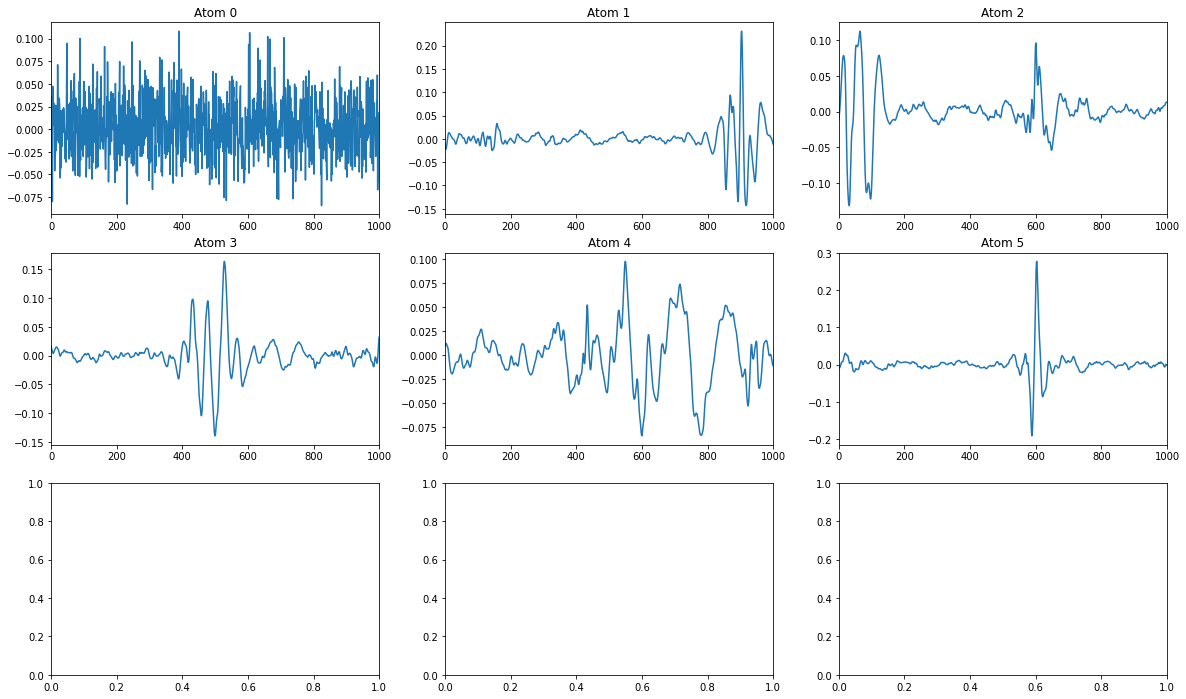

In [153]:
fig, ax_arr = plt.subplots(
    nrows=n_atoms // 3 + 1, ncols=3, figsize=(20, 4 * (n_atoms // 3 + 1))
)

for k, (atom, ax) in enumerate(zip(global_dict.squeeze().T, ax_arr.flatten())):
    ax.plot(atom)
    ax.set_xlim(0, atom.size)
    ax.set_title(f"Atom {k}")

For each signal of the data set, we compute the number of non-zeros activations and the reconstruction error.

In [154]:
for (label, signal) in zip(y, X):
    codes = learn_codes(
        signal=signal, atom_dictionary=global_dict, penalty=penalty
    )
    error = compute_error(
        signal=signal, atom_dictionary=global_dict, codes=codes
    )
    nnz_activations = (codes > 1e-3).sum()
    # select two most used atoms
    most_used_atoms_activations, most_used_atoms_indexes = get_n_largest(
        (codes > 1e-3).sum(axis=0), n_largest=1
    )
    most_used_atom_msg = ", ".join(
        f"{ind} ({acti*100/nnz_activations:.1f}%)"
        for (acti, ind) in zip(
            most_used_atoms_activations, most_used_atoms_indexes
        )
    )
    print(
        f"Label: {label}, MSE: {error:.2f}, non-zero activations: {nnz_activations}, most used atoms: {most_used_atom_msg}"
    )

Label: Abnormal, MSE: 0.41, non-zero activations: 125, most used atoms: 3 (38.4%)
Label: Abnormal, MSE: 0.42, non-zero activations: 200, most used atoms: 4 (57.0%)
Label: Abnormal, MSE: 0.30, non-zero activations: 72, most used atoms: 5 (41.7%)
Label: Normal, MSE: 0.47, non-zero activations: 186, most used atoms: 4 (32.3%)
Label: Normal, MSE: 0.31, non-zero activations: 97, most used atoms: 1 (53.6%)
Label: Normal, MSE: 1.44, non-zero activations: 136, most used atoms: 2 (87.5%)


Using the `Audio` function, we can listen to the learned dictionary and the reconstructed signals.

In [156]:
for (label, signal) in zip(y, X):
    codes = learn_codes(
        signal=signal, atom_dictionary=global_dict, penalty=penalty
    )

    reconstruction = np.sum(
        [
            np.convolve(code, atom, mode="valid")
            for (code, atom) in zip(codes.T, global_dict.squeeze().T)
        ],
        axis=0,
    )
    print(label)
    print("\tOriginal", end=" ")
    display(Audio(signal.flatten(), rate=FREQUENCY))
    print("\tReconstruction", end=" ")
    display(Audio(reconstruction, rate=FREQUENCY))

Abnormal
	Original 	Reconstruction Abnormal
	Original 	Reconstruction Abnormal
	Original 	Reconstruction Normal
	Original 	Reconstruction Normal
	Original 	Reconstruction Normal
	Original 	Reconstruction 

The noise has been removed. For the worst approximated signal, some hearbeats have been skipped.

# Distance between signals (DTW)

## Data

In [7]:
dataset_name = "FiftyWords"
data = load_uea_ucr_data(dataset_name)
print(data.description)

FiftyWords is a data set of word outlines taken from the George
Washington library by T. Rath and used in the paper "Word image
matching using dynamic time warping", CVPR 2003.

Each case is a word. A series is formed by taking the height
profile of the word.



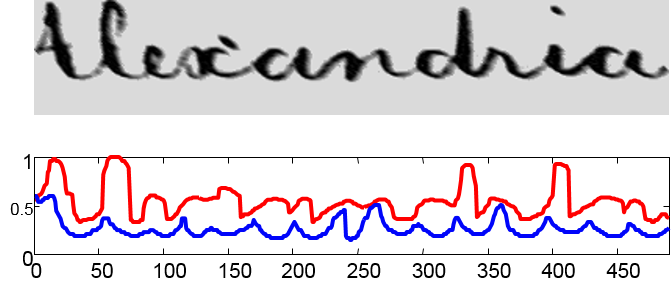

Here, we only deal with the top profile (in red).

In [8]:
profiles = data.X_train
labels = data.y_train

# normalize signals (zero mean, unit variance).
profiles -= profiles.mean(axis=1).reshape(-1, 1, 1)
profiles /= profiles.std(axis=1).reshape(-1, 1, 1)

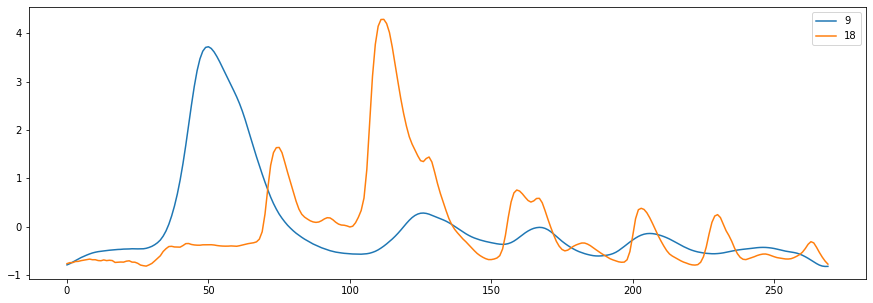

In [9]:
word_1, label_1 = profiles[0].flatten(), labels[0]
word_2, label_2 = profiles[1].flatten(), labels[1]
fig, ax = fig_ax()
ax.plot(word_1, label=label_1)
ax.plot(word_2, label=label_2)
_ = plt.legend()

## DTW between two signals

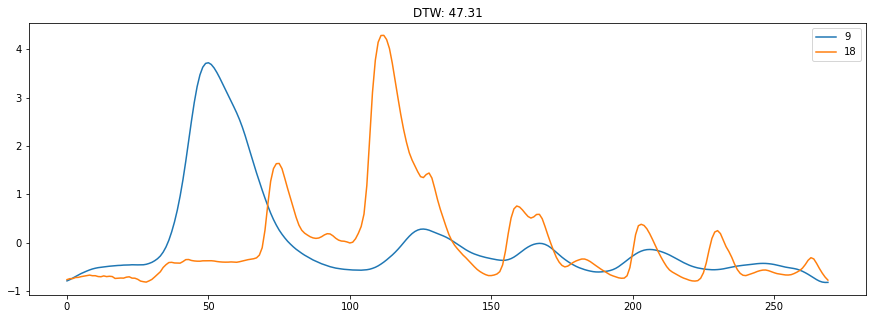

In [10]:
alignment = dtw(word_1, word_2, keep_internals=True)
fig, ax = fig_ax()
ax.plot(word_1, label=label_1)
ax.plot(word_2, label=label_2)
plt.title(f"DTW: {alignment.distance:.2f}")
_ = plt.legend()

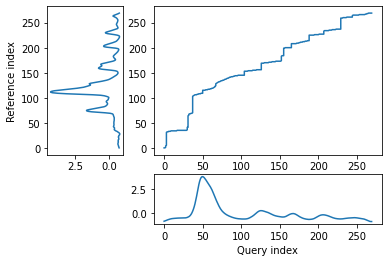

<AxesSubplot:>

In [11]:
alignment.plot(type="threeway")

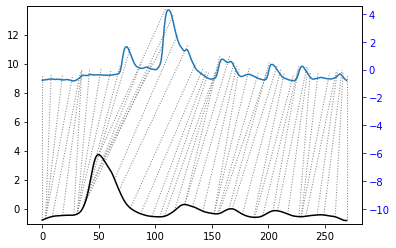

<AxesSubplot:>

In [12]:
alignment.plot(type="twoway", offset=10)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Write a function  which computes the DTW distance between two signals: <tt>get_dtw_distance(signal_1: np.ndarray, signal_2: np.ndarray)->float</tt>.</p>
</div>

In [13]:
def get_dtw_distance(signal_1: np.ndarray, signal_2: np.ndarray) -> float:
    return dtw(signal_1, signal_2).distance

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Choose a word and plot the most similar and the most dissimilar, according to the DTW. In addition, print the associated labels.</p>
</div>

In [14]:
word, label = profiles[65].flatten(), labels[65]
max_i=-1
min_i=get_dtw_distance(word,word_1)
for i in range(len(profiles)):
    if i!=65:
        word_i, label_i= profiles[i].flatten(), labels[i]
        a=get_dtw_distance(word_i,word)
        if a>max_i:
            max_i=a
            max_idx=i
        if a<min_i:
            min_i=a
            min_idx=i


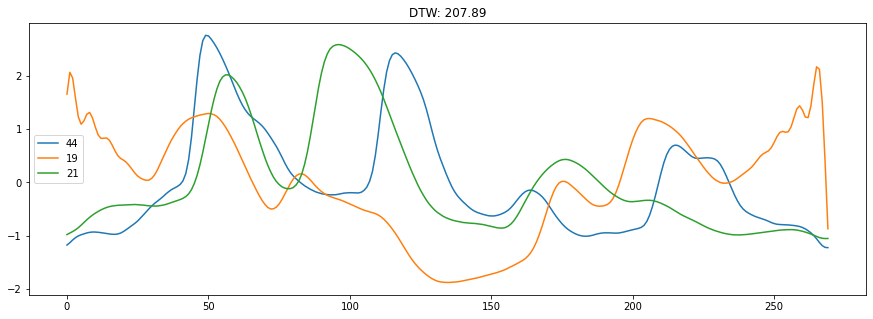

In [15]:
word_1, label_1 = profiles[max_idx].flatten(), labels[max_idx]
word_2, label_2 = profiles[min_idx].flatten(), labels[min_idx]

alignment = dtw(word, word_1, keep_internals=True)
alignment1 = dtw(word, word_2, keep_internals=True)

fig, ax = fig_ax()
ax.plot(word, label=label)
ax.plot(word_1, label=label_1)
ax.plot(word_2, label=label_2)
plt.title(f"DTW: {alignment.distance:.2f}")
_ = plt.legend()

## Clustering with DTW

### Clustering a small subset

Out of the whole data set, let us choose 6 word profiles from 2 classes.

In [16]:
# select a few profiles with two different classes
keep_mask = np.isin(labels, ["31", "34"])
labels_sub = labels[keep_mask]
profiles_sub = profiles[keep_mask]
# reorder by label
order_indexes = labels_sub.argsort()
labels_sub = labels_sub[order_indexes]
profiles_sub = profiles_sub[order_indexes]

Compute the distance matrix $D$ of this smaller data set: $D_{ij} = d(x_i, x_j)$.

In [17]:
# init
distance_matrix = np.zeros(
    (profiles_sub.shape[0], profiles_sub.shape[0]), dtype=float
)

for row in range(profiles_sub.shape[0]):
    for col in range(row + 1, profiles_sub.shape[0]):
        distance_matrix[row, col] = get_dtw_distance(
            profiles_sub[row], profiles_sub[col]
        )
        distance_matrix[col, row] = distance_matrix[row, col]

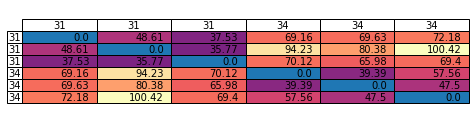

In [18]:
_ = display_distance_matrix_as_table(
    np.round(distance_matrix, 2), labels=labels_sub
)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Create the same plot (distance matrix) with the Euclidean distance instead of the DTW. What do you observe?</p>
</div>



In [19]:
distance_matrix = pdist(
    profiles_sub.squeeze(), metric="euclidean"
) #%%


ValueError: Invalid RGBA argument: 0.616999

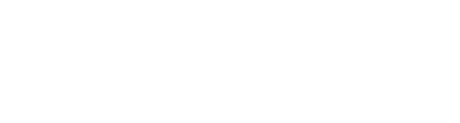

In [21]:
_ = display_distance_matrix_as_table(
    np.round(distance_matrix, 2), labels=labels_sub
)
# i kept getting this error i didn't succed to plot the matrix

### Clustering on a larger subset

Using the DTW, we can cluster a large set of data (43 words).

In [22]:
# select a few profiles with two different classes
keep_mask = np.isin(labels, ["4", "6", "14"])
profiles_sub = profiles[keep_mask]
labels_sub = labels[keep_mask]

Compute the distance matrix with the DTW.

In [38]:
# Instead of the previous double for loop, we can use scipy function pdist
distance_matrix = pdist(
    profiles_sub.squeeze(), metric=get_dtw_distance
)  # condensed distance matrix
# Compute linkage matrix using the 'ward' criterion
linkage = hierarchy.ward(distance_matrix)

Plot the linkage as a dendogram.

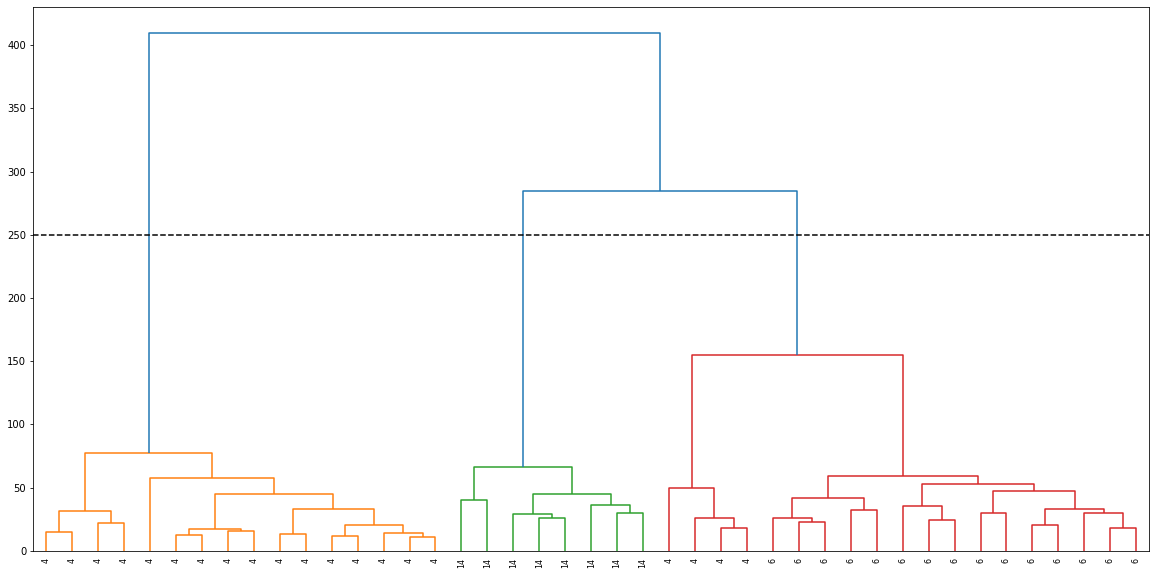

In [40]:
fig, ax = fig_ax((20, 10))

cut_threshold = 250

dendro = hierarchy.dendrogram(
    linkage,
    ax=ax,
    labels=labels_sub,
    color_threshold=cut_threshold,
    distance_sort=True,
)
ax.axhline(cut_threshold, ls="--", color="k")

Do the same clustering with the Euclidean distance instead.

In [41]:
# Instead of the previous double for loop, we can use scipy function pdist
distance_matrix = pdist(
    profiles_sub.squeeze(), metric="euclidean"
)  # condensed distance matrix
# Compute linkage matrix using the 'ward' criterion
linkage = hierarchy.ward(distance_matrix)

Plot the linkage as a dendogram.

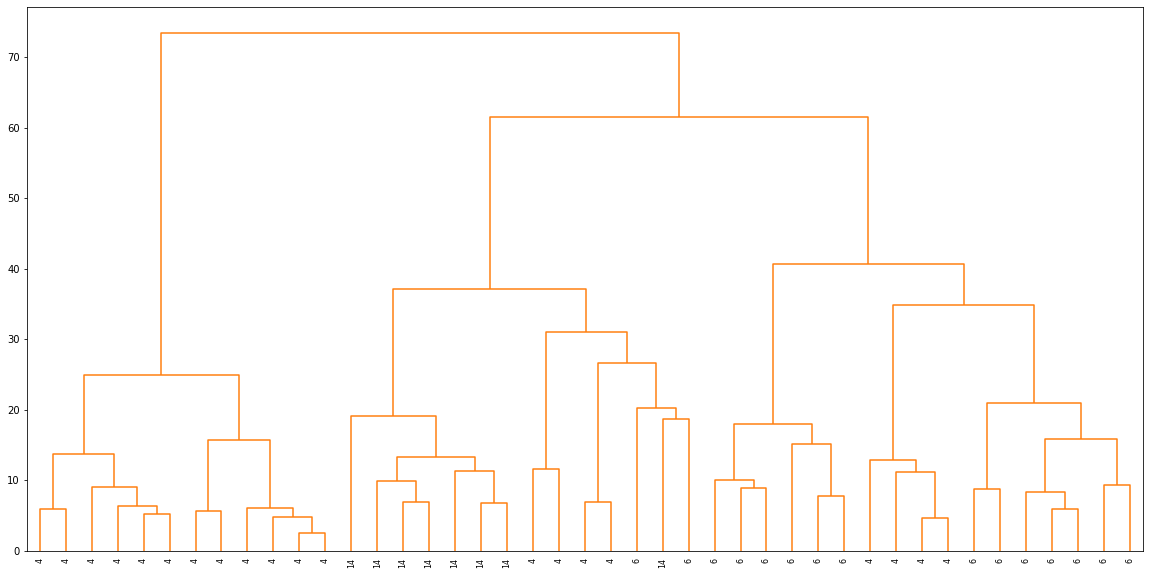

In [42]:
fig, ax = fig_ax((20, 10))

cut_threshold = 350

dendro = hierarchy.dendrogram(
    linkage,
    ax=ax,
    labels=labels_sub,
    color_threshold=cut_threshold,
    distance_sort=True,
)
ax.axhline(cut_threshold, ls="--", color="k")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>In the previous dendrograms, change the <tt>cut_threshold</tt> argument to have homogeneous clusters (as much as possible).</p>
</div>

I chose the thresolds above, with the ruclidian distance
it is impossible to have homogenous clusters(clusters with few
elements are not of interest)
